In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
df=pd.read_csv('data.csv',delimiter=',', encoding='ISO-8859-1')
df.head(5)
rows_with_nulls = df[df.isnull().any(axis=1)]

rows_with_nulls

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [16]:
df=df.dropna() # enlever les valeurs nulles
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate']) # transformation de la colonne date
df['Description']=df['Description'].str.upper() # on passe les descriptions en masjuscule

In [4]:
# On remplace chaque déscription par le nom le plus fréquent
Description_frequente=df.groupby('StockCode')['Description'].apply(lambda x : x.mode().iloc[0]).reset_index()
# on récupere un vecteur stockcode description sans doublants
Description_frequente=Description_frequente[~Description_frequente['Description'].duplicated(keep=False)]


In [5]:
# modifier les descriptions dans le df
stockcode_description_mapping = Description_frequente.set_index('StockCode')['Description'].to_dict()
df['Description'] = df['StockCode'].map(stockcode_description_mapping)
duplicates = Description_frequente.duplicated(subset='Description', keep=False)

Afficher les 30 articles les plus achetés

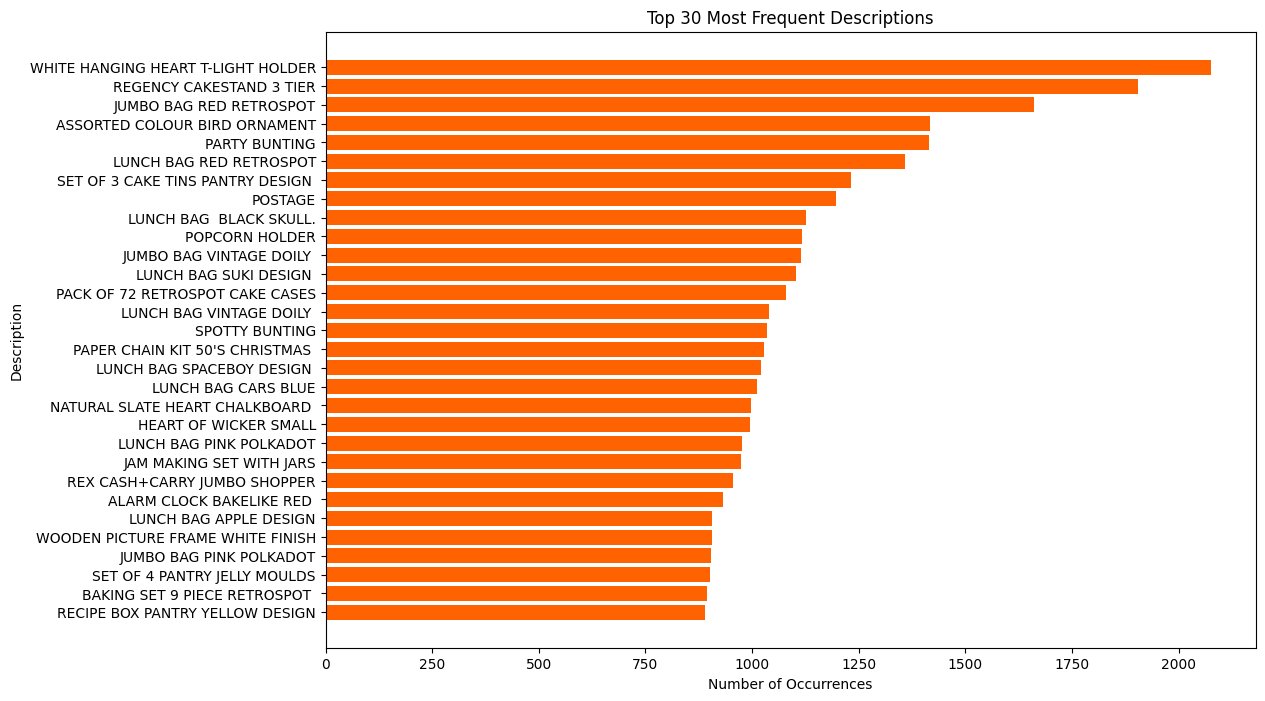

In [7]:
des_count=df['Description'].value_counts()
top_30_descriptions=des_count[:30]
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [8]:
#on enleve les stockcode qui ne correspondent pas a des articles (bank charges ...)
df=df[~df['StockCode'].str.match(r'^[A-Za-z]')]

In [10]:
top_products_by_country = df.groupby(['Country', 'Description']).size().reset_index(name='NombreAchats')
top_products_by_country = top_products_by_country.sort_values(['NombreAchats'], ascending=[False])
top_3_products_by_country = top_products_by_country.groupby('Country')
top_3_products_by_country.head()


,Country,Description,NombreAchats
18464,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,1987
17593,United Kingdom,REGENCY CAKESTAND 3 TIER,1574
16654,United Kingdom,JUMBO BAG RED RETROSPOT,1505
15217,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,1343
17190,United Kingdom,PARTY BUNTING,1327
...,...,...,...
12260,RSA,CLASSIC GLASS COOKIE JAR,1
12308,Saudi Arabia,ASSORTED BOTTLE TOP MAGNETS,1
12310,Saudi Arabia,GLASS JAR MARMALADE,1
12311,Saudi Arabia,GLASS JAR PEACOCK BATH SALTS,1


In [11]:
# on genre la matrice invoice products
MIP=df.pivot_table(index='InvoiceNo', columns='Description',values='Quantity',aggfunc='sum', fill_value=0)
# on la passe en binaire
MIP_binary=MIP.applymap(lambda x: 1 if x > 0 else 0)

C:\Users\etulyon1\AppData\Local\Temp\ipykernel_9236\2381299319.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MIP_binary=MIP.applymap(lambda x: 1 if x > 0 else 0)


In [11]:
MCP_binary.shape

(21781, 3641)

In [13]:
# recherche des produits fréquent en allant jusqu'aux combinaison de 3 produits
supports=apriori(MCP_binary,min_support=0.01,max_len=3,use_colnames=True)
supports.sort_values(by="support",ascending=False).head(5)

C:\Users\etulyon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
489,0.090813,(WHITE HANGING HEART T-LIGHT HOLDER)
349,0.078233,(REGENCY CAKESTAND 3 TIER)
204,0.073459,(JUMBO BAG RED RETROSPOT)
286,0.063358,(PARTY BUNTING)
30,0.063128,(ASSORTED COLOUR BIRD ORNAMENT)


In [19]:
# on s'interesse aux ensemble de 2 produits
pd.set_option("display.max_colwidth", None)
# compter la taille des ensembles
supports["len"] = supports["itemsets"].apply(lambda x: len(x))
# affichage des top 20, ensembles de 2 produits les plus fréquents
G3items=supports[supports["len"]==2].sort_values(by="support", ascending=False)

In [20]:
G3items

,support,itemsets,len
597,0.025068,"(JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKADOT)",2
564,0.024838,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )",2
530,0.024333,"(ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKELIKE RED )",2
677,0.024012,"(LUNCH BAG PINK POLKADOT, LUNCH BAG RED RETROSPOT)",2
683,0.023828,"(LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN )",2
...,...,...,...
723,0.010146,"(RETROSPOT HEART HOT WATER BOTTLE, SCOTTIE DOG HOT WATER BOTTLE)",2
528,0.010101,"(ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKELIKE ORANGE)",2
710,0.010055,"(PLASTERS IN TIN STRONGMAN, PLASTERS IN TIN CIRCUS PARADE )",2
719,0.010009,"(SET OF 3 CAKE TINS PANTRY DESIGN , REGENCY CAKESTAND 3 TIER)",2


In [ ]:
# on calcule les regles d'association
rules = association_rules(supports, min_threshold=0.05)
# on ordonne selon la metric lift
rules.sort_values(by="lift", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
184,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER)",(PINK REGENCY TEACUP AND SAUCER),0.067385,0.073115,0.055696,0.826531,11.304555,0.050769,5.343220,0.977402
189,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER)",0.073115,0.067385,0.055696,0.761755,11.304555,0.050769,3.914529,0.983444
195,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )",0.073115,0.073115,0.059592,0.815047,11.147493,0.054246,5.011464,0.982100
190,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )",(PINK REGENCY TEACUP AND SAUCER),0.073115,0.073115,0.059592,0.815047,11.147493,0.054246,5.011464,0.982100
193,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENCY TEACUP AND SAUCER)",0.088471,0.061884,0.059592,0.673575,10.884475,0.054117,2.873911,0.996267
192,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENCY TEACUP AND SAUCER)",(GREEN REGENCY TEACUP AND SAUCER),0.061884,0.088471,0.059592,0.962963,10.884475,0.054117,24.611277,0.968032
186,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP AND SAUCER)",(GREEN REGENCY TEACUP AND SAUCER),0.058675,0.088471,0.055696,0.949219,10.729123,0.050505,17.950105,0.963319
187,(GREEN REGENCY TEACUP AND SAUCER),"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP AND SAUCER)",0.088471,0.058675,0.055696,0.629534,10.729123,0.050505,2.540919,0.994808
15,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.073802,0.065780,0.051341,0.695652,10.575367,0.046486,3.069579,0.977589
14,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.065780,0.073802,0.051341,0.780488,10.575367,0.046486,4.219344,0.969195


In [ ]:
rules.sort_values(by="confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
192,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENCY TEACUP AND SAUCER)",(GREEN REGENCY TEACUP AND SAUCER),0.061884,0.088471,0.059592,0.962963,10.884475,0.054117,24.611277,0.968032
186,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP AND SAUCER)",(GREEN REGENCY TEACUP AND SAUCER),0.058675,0.088471,0.055696,0.949219,10.729123,0.050505,17.950105,0.963319
19,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.073115,0.088471,0.067843,0.927900,10.488151,0.061375,12.642508,0.976016
12,(CANDLEHOLDER PINK HANGING HEART),(WHITE HANGING HEART T-LIGHT HOLDER),0.057758,0.195737,0.052487,0.908730,4.642611,0.041181,8.811926,0.832699
222,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP AND SAUCER)",(ROSES REGENCY TEACUP AND SAUCER ),0.058675,0.096493,0.052258,0.890625,9.229921,0.046596,8.260633,0.947236
191,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER)",(ROSES REGENCY TEACUP AND SAUCER ),0.067843,0.096493,0.059592,0.878378,9.103004,0.053046,7.428833,0.954932
197,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER)",(ROSES REGENCY TEACUP AND SAUCER ),0.067385,0.096493,0.058446,0.867347,8.988681,0.051944,6.811051,0.952964
161,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.073115,0.096493,0.061884,0.846395,8.771547,0.054829,5.882013,0.955884
220,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENCY TEACUP AND SAUCER)",(REGENCY CAKESTAND 3 TIER),0.061884,0.199404,0.052258,0.844444,4.234840,0.039918,5.146688,0.814253
184,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER)",(PINK REGENCY TEACUP AND SAUCER),0.067385,0.073115,0.055696,0.826531,11.304555,0.050769,5.343220,0.977402


In [ ]:
grouped_data = df.groupby(['Country', 'Description']).size().reset_index(name='ventes')

# Triez les données par pays et ventes dans l'ordre décroissant
sorted_data = grouped_data.sort_values(['Country', 'ventes'], ascending=[True, False])

# Sélectionnez les trois produits les plus vendus dans chaque pays
top_3_products = sorted_data.groupby('Country').head(3)

print(top_3_products)


              Country                         Description  ventes
457         Australia   SET OF 3 CAKE TINS PANTRY DESIGN       10
251         Australia             LUNCH BAG RED RETROSPOT       9
394         Australia       RED TOADSTOOL LED NIGHT LIGHT       9
824           Austria    RETROSPOT TEA SET CERAMIC 11 PC        4
834           Austria  ROUND SNACK BOXES SET OF 4 FRUITS        4
...               ...                                 ...     ...
17593  United Kingdom            REGENCY CAKESTAND 3 TIER    1574
16654  United Kingdom             JUMBO BAG RED RETROSPOT    1505
18655     Unspecified       ASSORTED COLOUR BIRD ORNAMENT       3
18681     Unspecified        COSY HOUR CIGAR BOX MATCHES        3
18788     Unspecified          SET OF 10 LED DOLLY LIGHTS       3

[111 rows x 3 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
